#### Load necessary packages

In [1]:
import numpy as np
import xarray as xr
import pickle
import math
import matplotlib.pyplot as plt
import warnings
import cftime
import scipy

In [2]:
glodap = scipy.io.loadmat("../data/GLODAPv2.2023_Merged_Master_File.mat")
glodap.keys()

dict_keys(['__header__', '__version__', '__globals__', 'G2cruise', 'G2station', 'G2region', 'G2cast', 'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute', 'G2latitude', 'G2longitude', 'G2bottomdepth', 'G2maxsampdepth', 'G2bottle', 'G2pressure', 'G2depth', 'G2temperature', 'G2theta', 'G2salinity', 'G2salinityf', 'G2salinityqc', 'G2sigma0', 'G2sigma1', 'G2sigma2', 'G2sigma3', 'G2sigma4', 'G2gamma', 'G2oxygen', 'G2oxygenf', 'G2oxygenqc', 'G2aou', 'G2aouf', 'G2nitrate', 'G2nitratef', 'G2nitrateqc', 'G2nitrite', 'G2nitritef', 'G2silicate', 'G2silicatef', 'G2silicateqc', 'G2phosphate', 'G2phosphatef', 'G2phosphateqc', 'G2tco2', 'G2tco2f', 'G2tco2qc', 'G2talk', 'G2talkf', 'G2talkqc', 'G2fco2', 'G2fco2f', 'G2fco2temp', 'G2phts25p0', 'G2phts25p0f', 'G2phtsinsitutp', 'G2phtsinsitutpf', 'G2phtsqc', 'G2cfc11', 'G2pcfc11', 'G2cfc11f', 'G2cfc11qc', 'G2cfc12', 'G2pcfc12', 'G2cfc12f', 'G2cfc12qc', 'G2cfc113', 'G2pcfc113', 'G2cfc113f', 'G2cfc113qc', 'G2ccl4', 'G2pccl4', 'G2ccl4f', 'G2ccl4qc', 'G2sf6', '

In [3]:
# cut out values deeper than 10m
glodap_surf = {}
is_surf = glodap["G2depth"] <= 10

for key in glodap.keys():
    if isinstance(glodap[key], np.ndarray) and glodap[key].shape == is_surf.shape:
        glodap_surf[key] = glodap[key][is_surf]

In [4]:
glodap_surf.keys()

dict_keys(['G2cruise', 'G2station', 'G2region', 'G2cast', 'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute', 'G2latitude', 'G2longitude', 'G2bottomdepth', 'G2maxsampdepth', 'G2bottle', 'G2pressure', 'G2depth', 'G2temperature', 'G2theta', 'G2salinity', 'G2salinityf', 'G2salinityqc', 'G2sigma0', 'G2sigma1', 'G2sigma2', 'G2sigma3', 'G2sigma4', 'G2gamma', 'G2oxygen', 'G2oxygenf', 'G2oxygenqc', 'G2aou', 'G2aouf', 'G2nitrate', 'G2nitratef', 'G2nitrateqc', 'G2nitrite', 'G2nitritef', 'G2silicate', 'G2silicatef', 'G2silicateqc', 'G2phosphate', 'G2phosphatef', 'G2phosphateqc', 'G2tco2', 'G2tco2f', 'G2tco2qc', 'G2talk', 'G2talkf', 'G2talkqc', 'G2fco2', 'G2fco2f', 'G2fco2temp', 'G2phts25p0', 'G2phts25p0f', 'G2phtsinsitutp', 'G2phtsinsitutpf', 'G2phtsqc', 'G2cfc11', 'G2pcfc11', 'G2cfc11f', 'G2cfc11qc', 'G2cfc12', 'G2pcfc12', 'G2cfc12f', 'G2cfc12qc', 'G2cfc113', 'G2pcfc113', 'G2cfc113f', 'G2cfc113qc', 'G2ccl4', 'G2pccl4', 'G2ccl4f', 'G2ccl4qc', 'G2sf6', 'G2psf6', 'G2sf6f', 'G2sf6qc', 'G2c13', 'G2c1

In [5]:
glodap_all = {}
glodap_talk_tco2_only = {}
talk_tco2_good = np.logical_and(glodap_surf["G2talk"] > 1000,
                                glodap_surf["G2tco2"] > 1000)

silicate_phosphate_good = np.logical_and(glodap_surf["G2silicate"] > 0,
                                         glodap_surf["G2phosphate"] > 0)

all_good = np.logical_and(talk_tco2_good, silicate_phosphate_good)

only_talk_tco2_good = np.logical_and(talk_tco2_good, 
                                     np.logical_not(silicate_phosphate_good))

is_between_1993_2022 = np.logical_and(glodap_surf["G2year"] >= 1993,
                                      glodap_surf["G2year"] <= 2022)


for key in ["G2talk", "G2tco2", "G2silicate", "G2phosphate",
           "G2year", "G2month", "G2latitude", "G2longitude"]:
    glodap_all[key] = glodap_surf[key][np.logical_and(all_good, is_between_1993_2022)]
    glodap_talk_tco2_only[key] = glodap_surf[key][np.logical_and(only_talk_tco2_good, is_between_1993_2022)]

In [6]:
print("glodap_all has {} data points.".format(glodap_all["G2talk"].shape[0]))
print("glodap_talk_tco2_only has {} data points.".format(
    glodap_talk_tco2_only["G2talk"].shape[0]))
print("")
print("Do quality checks of the data:")
print("glodap_all['G2month'] between {} and {}".format(
    np.min(glodap_all["G2month"]), np.max(glodap_all["G2month"])))
print("glodap_talk_tco2_only['G2month'] between {} and {}".format(
    np.min(glodap_talk_tco2_only["G2month"]), np.max(glodap_talk_tco2_only["G2month"])))
print("")
print("glodap_all['G2year'] between {} and {}".format(
    np.min(glodap_all["G2year"]), np.max(glodap_all["G2year"])))
print("glodap_talk_tco2_only['G2year'] between {} and {}".format(
    np.min(glodap_talk_tco2_only["G2year"]), np.max(glodap_talk_tco2_only["G2year"])))
print("")
print("glodap_all['G2latitude'] between {} and {}".format(
    np.min(glodap_all["G2latitude"]), np.max(glodap_all["G2latitude"])))
print("glodap_talk_tco2_only['G2latitude'] between {} and {}".format(
    np.min(glodap_talk_tco2_only["G2latitude"]), np.max(glodap_talk_tco2_only["G2latitude"])))
print("")
print("glodap_all['G2longitude'] between {} and {}".format(
    np.min(glodap_all["G2longitude"]), np.max(glodap_all["G2longitude"])))
print("glodap_talk_tco2_only['G2longitude'] between {} and {}".format(
    np.min(glodap_talk_tco2_only["G2longitude"]), np.max(glodap_talk_tco2_only["G2longitude"])))
print("")
print("glodap_all['G2talk'] between {} and {}".format(
    np.min(glodap_all["G2talk"]), np.max(glodap_all["G2talk"])))
print("glodap_talk_tco2_only['G2talk'] between {} and {}".format(
    np.min(glodap_talk_tco2_only["G2talk"]), np.max(glodap_talk_tco2_only["G2talk"])))
print("")
print("glodap_all['G2tco2'] between {} and {}".format(
    np.min(glodap_all["G2tco2"]), np.max(glodap_all["G2tco2"])))
print("glodap_talk_tco2_only['G2tco2'] between {} and {}".format(
    np.min(glodap_talk_tco2_only["G2tco2"]), np.max(glodap_talk_tco2_only["G2tco2"])))
print("")
print("glodap_all['G2silicate'] between {} and {}".format(
    np.min(glodap_all["G2silicate"]), np.max(glodap_all["G2silicate"])))
print("glodap_talk_tco2_only['G2silicate'] between {} and {}".format(
    np.min(glodap_talk_tco2_only["G2silicate"]), np.max(glodap_talk_tco2_only["G2silicate"])))
print("")
print("glodap_all['G2phosphate'] between {} and {}".format(
    np.min(glodap_all["G2phosphate"]), np.max(glodap_all["G2phosphate"])))
print("glodap_talk_tco2_only['G2phosphate'] between {} and {}".format(
    np.min(glodap_talk_tco2_only["G2phosphate"]), np.max(glodap_talk_tco2_only["G2phosphate"])))

glodap_all has 19205 data points.
glodap_talk_tco2_only has 6948 data points.

Do quality checks of the data:
glodap_all['G2month'] between 1.0 and 12.0
glodap_talk_tco2_only['G2month'] between 1.0 and 12.0

glodap_all['G2year'] between 1993.0 and 2021.0
glodap_talk_tco2_only['G2year'] between 1993.0 and 2021.0

glodap_all['G2latitude'] between -78.04 and 89.987
glodap_talk_tco2_only['G2latitude'] between -76.485 and 86.968

glodap_all['G2longitude'] between -179.89 and 236.7562
glodap_talk_tco2_only['G2longitude'] between -179.77 and 234.4987

glodap_all['G2talk'] between 1000.6 and 2829.4
glodap_talk_tco2_only['G2talk'] between 1256.1 and 2853.1

glodap_all['G2tco2'] between 1002.5 and 2664.2
glodap_talk_tco2_only['G2tco2'] between 1230.3 and 2620.8

glodap_all['G2silicate'] between 0.0095 and 167.22
glodap_talk_tco2_only['G2silicate'] between nan and nan

glodap_all['G2phosphate'] between 0.00092915 and 2.68
glodap_talk_tco2_only['G2phosphate'] between nan and nan


In [7]:
mean_array_all = [np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan)]

num_array_all = np.zeros((360, 180, 360))

mean_array_talk_tco2_only = [np.full((360, 180, 360), np.nan),
                            np.full((360, 180, 360), np.nan)]

num_array_talk_tco2_only = np.zeros((360, 180, 360))

# first grid GLODAP data with all four variables available
for i in range(len(glodap_all["G2year"])):
    time_index = int(12 * (
        glodap_all["G2year"][i] - 1993) + glodap_all["G2month"][i] - 1)
    lat_index = math.floor(glodap_all["G2latitude"][i]) + 90
    lon_index = math.floor(glodap_all["G2longitude"][i]) + 180
    # if longitude is given as 180.5°E, this should be index 0
    # (since corresponding to between -180°E and -179°E)
    if lon_index >= 360: 
        lon_index -= 360
    
    num_array_all[time_index, lat_index, lon_index] += 1
    num_obs = num_array_all[time_index, lat_index, lon_index]

    if num_obs == 1:
        for j, key in enumerate(["G2talk", "G2tco2", "G2silicate", "G2phosphate"]):
            mean_array_all[j][time_index, lat_index, lon_index] = glodap_all[key][i]
    elif num_obs > 1:
        for j, key in enumerate(["G2talk", "G2tco2", "G2silicate", "G2phosphate"]):
            mean_array_all[j][time_index, lat_index, lon_index] = (
                (num_obs-1) / num_obs *  mean_array_all[j][
                            time_index, lat_index, lon_index]
                         + 1 / num_obs * glodap_all[key][i])


# # Grid GLODAP data with only talk and tco2 available
for i in range(len(glodap_talk_tco2_only["G2year"])):
    time_index = int(12 * (
        glodap_talk_tco2_only["G2year"][i] - 1993
    ) + glodap_talk_tco2_only["G2month"][i] - 1)
    lat_index = math.floor(glodap_talk_tco2_only["G2latitude"][i]) + 90
    lon_index = math.floor(glodap_talk_tco2_only["G2longitude"][i]) + 180
    # if longitude is given as 180.5°E, this should be index 0
    # (since corresponding to between -180°E and -179°E)
    if lon_index >= 360: 
        lon_index -= 360
    
    num_array_talk_tco2_only[time_index, lat_index, lon_index] += 1
    num_obs = num_array_talk_tco2_only[time_index, lat_index, lon_index]

    if num_obs == 1:
        for j, key in enumerate(["G2talk", "G2tco2"]):
            mean_array_talk_tco2_only[j][
            time_index, lat_index, lon_index] = glodap_talk_tco2_only[key][i]
    elif num_obs > 1:
        for j, key in enumerate(["G2talk", "G2tco2"]):
            mean_array_talk_tco2_only[j][time_index, lat_index, lon_index] = (
                (num_obs-1) / num_obs *  mean_array_talk_tco2_only[j][
                            time_index, lat_index, lon_index]
                         + 1 / num_obs * glodap_talk_tco2_only[key][i])

Number of GLODAP samples with all four variables: 19205
Number of grid cells with GLODAP samples with all four variables: 11254


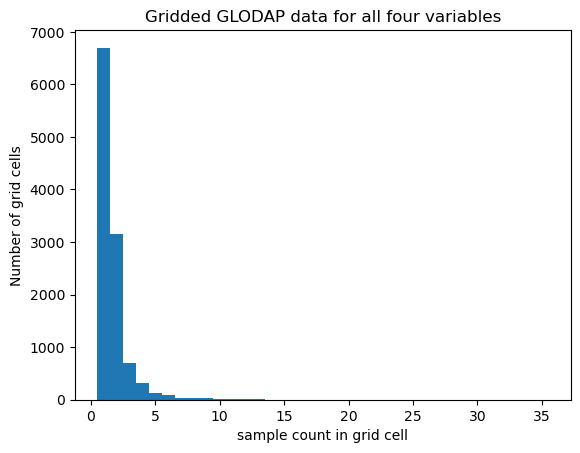

In [8]:
plt.hist(num_array_all[num_array_all > 0], bins=np.arange(0.5, 36.5))
plt.title("Gridded GLODAP data for all four variables")
plt.xlabel("sample count in grid cell")
plt.ylabel("Number of grid cells")
print("Number of GLODAP samples with all four variables: {}".format(
    int(np.sum(num_array_all))))
print("Number of grid cells with GLODAP samples with all four variables: {}".format(
    int(np.sum(np.isfinite(mean_array_all[0])))))

Number of GLODAP samples with talk and tco2 only: 6948
Number of grid cells with GLODAP samples with talk and tco2 only: 4182


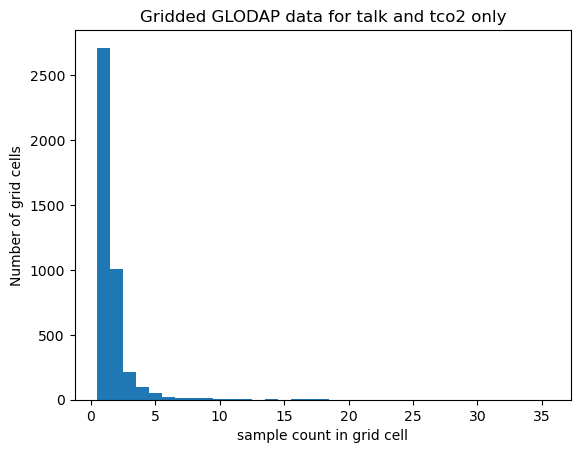

In [9]:
plt.hist(num_array_talk_tco2_only[num_array_talk_tco2_only > 0],
         bins=np.arange(0.5, 36.5))
plt.title("Gridded GLODAP data for talk and tco2 only")
plt.xlabel("sample count in grid cell")
plt.ylabel("Number of grid cells")
print("Number of GLODAP samples with talk and tco2 only: {}".format(
    int(np.sum(num_array_talk_tco2_only))))
print("Number of grid cells with GLODAP samples with talk and tco2 only: {}".format(
    int(np.sum(np.isfinite(mean_array_talk_tco2_only[0])))))

Histograms of gridded GLODAP data for all four variables


Text(0.5, 1.0, 'phosphate')

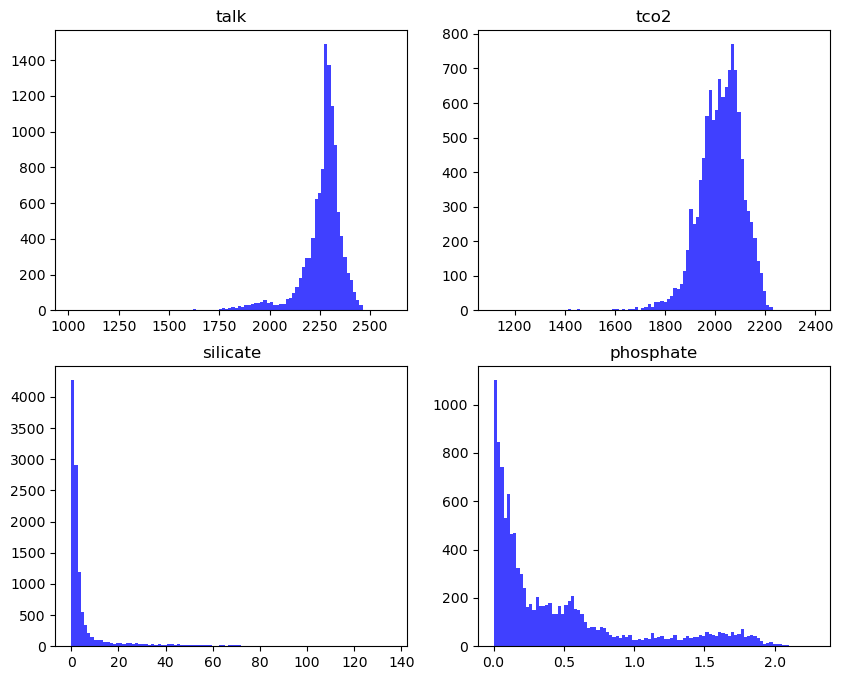

In [10]:
print("Histograms of gridded GLODAP data for all four variables")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].hist(mean_array_all[0][np.isfinite(mean_array_all[0])],
               bins=100, alpha=0.75, color='blue')
axs[0, 0].set_title('talk')

axs[0, 1].hist(mean_array_all[1][np.isfinite(mean_array_all[1])],
               bins=100, alpha=0.75, color='blue')
axs[0, 1].set_title('tco2')

axs[1, 0].hist(mean_array_all[2][np.isfinite(mean_array_all[2])],
               bins=100, alpha=0.75, color='blue')
axs[1, 0].set_title('silicate')

axs[1, 1].hist(mean_array_all[3][np.isfinite(mean_array_all[3])],
               bins=100, alpha=0.75, color='blue')
axs[1, 1].set_title('phosphate')

Histograms of gridded GLODAP data for talk and tco2 only


Text(0.5, 1.0, 'tco2')

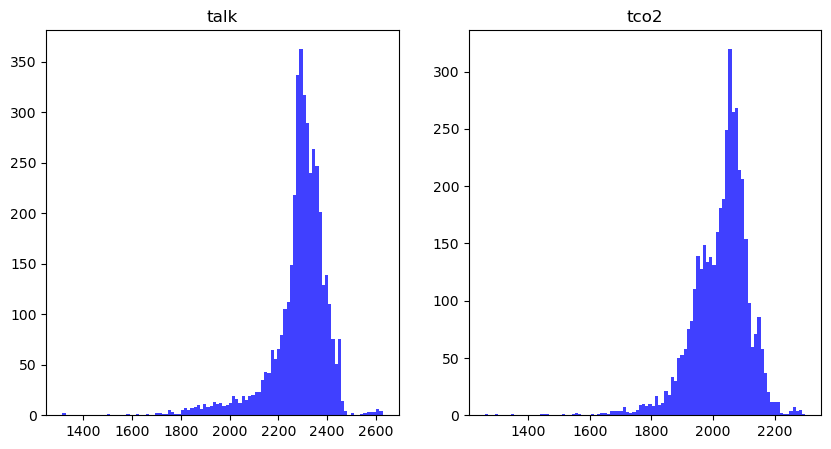

In [11]:
print("Histograms of gridded GLODAP data for talk and tco2 only")
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(mean_array_talk_tco2_only[0][np.isfinite(mean_array_talk_tco2_only[0])],
               bins=100, alpha=0.75, color='blue')
axs[0].set_title('talk')

axs[1].hist(mean_array_talk_tco2_only[1][np.isfinite(mean_array_talk_tco2_only[1])],
               bins=100, alpha=0.75, color='blue')
axs[1].set_title('tco2')

In [12]:
#create coordinates for xarray dataset for export
latitudes = np.arange(-89.5, 90)
longitudes = np.arange(-179.5, 180)

start_date = cftime.DatetimeGregorian(1993, 1, 15)
end_date = cftime.DatetimeGregorian(2023, 1, 15)
times = xr.cftime_range(start=start_date, end=end_date, freq="M")

In [13]:
ds_out_all = xr.Dataset()
for j, key in enumerate(["G2talk", "G2tco2", "G2silicate", "G2phosphate"]):
    ds_out_all[key] = xr.DataArray(
        mean_array_all[j], coords ={"time": times, "latitude": latitudes, "longitude": longitudes}
    ).astype('float32')

In [14]:
ds_out_all

<xarray.Dataset>
Dimensions:      (time: 360, latitude: 180, longitude: 360)
Coordinates:
  * time         (time) object 1993-01-31 00:00:00 ... 2022-12-31 00:00:00
  * latitude     (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude    (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    G2talk       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    G2tco2       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    G2silicate   (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    G2phosphate  (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [16]:
ds_out_all.to_netcdf("../data/GLODAPv2.2023_gridded_talk_tco2_silicate_phosphate.nc")

In [17]:
ds_out_talk_tco2_only = xr.Dataset()
for j, key in enumerate(["G2talk", "G2tco2"]):
    ds_out_talk_tco2_only[key] = xr.DataArray(
        mean_array_talk_tco2_only[j], coords ={"time": times, "latitude": latitudes, "longitude": longitudes}
    ).astype('float32')

In [18]:
ds_out_talk_tco2_only

<xarray.Dataset>
Dimensions:    (time: 360, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) object 1993-01-31 00:00:00 ... 2022-12-31 00:00:00
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    G2talk     (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    G2tco2     (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [19]:
ds_out_talk_tco2_only.to_netcdf("../data/GLODAPv2.2023_gridded_talk_tco2_only.nc")